# Modello Esponenziale {#sec-exponential-model}

**Prerequisiti**

**Concetti e competenze chiave**

- Comprendere la distribuzione esponenziale come un modello probabilistico adatto per descrivere i tempi di attesa.
- Sapere applicare il metodo basato su griglia per derivare la distribuzione a posteriori del parametro λ del modello Gamma-Esponenziale.
- Conoscere il modello coniugato Gamma-Esponenziale, dimostrando come la distribuzione a priori Gamma si combini con la verosimiglianza esponenziale per produrre una distribuzione a posteriori Gamma.
- Sapere come calcolare e interpretare le probabilità utilizzando la distribuzione a posteriori.

**Preparazione del Notebook**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import arviz as az
import warnings

warnings.filterwarnings("ignore")

In [3]:
# set seed to make the results fully reproducible
seed: int = sum(map(ord, "poisson-model"))
rng: np.random.Generator = np.random.default_rng(seed=seed)
sns.set_theme(palette="colorblind")
az.style.use("arviz-darkgrid")

%config InlineBackend.figure_format = "retina"

## Introduzione 

Nel contesto dell'inferenza bayesiana, il caso coniugato Gamma-Esponenziale rappresenta un potente strumento per modellare fenomeni che seguono una distribuzione esponenziale. La distribuzione esponenziale è spesso utilizzata per modellare il tempo tra eventi successivi in un processo che avviene a un tasso costante, come il tempo di attesa tra gli arrivi in una coda o la durata di certi eventi psicologici.

Ad esempio, in psicologia, possiamo utilizzare la distribuzione esponenziale per modellare la durata degli episodi di ansia o il tempo trascorso prima che un individuo manifesti un certo comportamento in risposta a uno stimolo. Supponiamo di osservare i tempi in cui diversi pazienti sperimentano episodi di disagio psicologico dopo un evento stressante. Questi tempi possono essere modellati utilizzando una distribuzione esponenziale, in cui il parametro $\lambda$ rappresenta il tasso con cui si verifica il disagio.

La verosimiglianza esponenziale per un campione di osservazioni indipendenti $y_1, y_2, \dots, y_n$, che rappresentano, ad esempio, i tempi di attesa fino a un episodio di disagio psicologico, è data da:

$$
f(y \mid \lambda) = \lambda^n e^{-\lambda \sum_{i=1}^{n} y_i}.
$$

In questo modello, $\lambda$ è il parametro che controlla il tasso medio di occorrenza degli eventi (ad esempio, episodi di disagio). Poiché spesso non conosciamo il valore di $\lambda$ a priori, possiamo utilizzare un approccio bayesiano per stimare $\lambda$, assumendo una distribuzione a priori su $\lambda$. Una scelta comune per la distribuzione a priori in questo contesto è la distribuzione Gamma, che è coniugata rispetto alla distribuzione esponenziale.

Quando si assume una distribuzione Gamma come prior su $\lambda$, la distribuzione a posteriori di $\lambda$, dopo aver osservato i dati, sarà anch'essa una distribuzione Gamma con parametri aggiornati. Questo aggiornamento incorpora le informazioni provenienti dai dati osservati, fornendo una stima più precisa del tasso di occorrenza degli eventi psicologici osservati. 

Ad esempio, dopo aver osservato i tempi di manifestazione del disagio psicologico in un gruppo di pazienti, possiamo aggiornare la nostra credenza su $\lambda$ e successivamente fare previsioni sui tempi futuri di occorrenza o valutare la probabilità di eventi specifici, come il verificarsi di un episodio severo di disagio psicologico.

## Distribuzione Esponenziale

La funzione di verosimiglianza per un campione di $n$ osservazioni indipendenti $X_1, X_2, \dots, X_n$ che seguono una distribuzione esponenziale con parametro $\lambda$ (dove $\lambda > 0$) è data dal prodotto delle densità di probabilità delle osservazioni.

La funzione di densità di probabilità (pdf) di una distribuzione esponenziale è:

$$
f(x \mid \lambda) = \lambda e^{-\lambda x}, \quad x \geq 0.
$$

Supponiamo di avere un campione di $n$ osservazioni indipendenti $X_1, X_2, \dots, X_n$. La funzione di verosimiglianza $L(\lambda)$ per questo campione è il prodotto delle pdf per tutte le osservazioni:

$$
L(\lambda \mid X_1, X_2, \dots, X_n) = \prod_{i=1}^{n} f(X_i \mid \lambda) = \prod_{i=1}^{n} \lambda e^{-\lambda X_i}.
$$

Sviluppando il prodotto, otteniamo:

$$
L(\lambda \mid X_1, X_2, \dots, X_n) = \lambda^n e^{-\lambda \sum_{i=1}^{n} X_i}.
$$

Questa è la funzione di verosimiglianza per il parametro $\lambda$ dato il campione $X_1, X_2, \dots, X_n$.

Per ottenere il logaritmo della funzione di verosimiglianza, che spesso è più facile da manipolare, calcoliamo:

$$
\log L(\lambda \mid X_1, X_2, \dots, X_n) = n \log \lambda - \lambda \sum_{i=1}^{n} X_i.
$$

La distribuzione esponenziale ha media pari a $1/\lambda$ e varianza $1/\lambda^2$.

### Dati

Simuliamo un campione di dati.

In [35]:
# Imposta il seed per rendere i risultati riproducibili
np.random.seed(42)

# Parametro lambda per la distribuzione esponenziale
mean = 3.0
lambda_param = 1 / mean

# Numero di osservazioni nel campione
n = 15

# Generazione del campione casuale

y = np.random.exponential(scale=mean, size=n).round()
print(y)

[ 1.  9.  4.  3.  1.  1.  0.  6.  3.  4.  0. 11.  5.  1.  1.]


Immaginiamo che questi dati corrispondano al punteggio totale della scala psicologica di Kessler (K6) di 14 individui -- si veda il @sec-cont-rv-distr. La media del campione è

In [ ]:
np.mean(y)

### Passi per definire un prior debolmente informativo

Imponiamo una distribuzione Gamma quale distribuzione a priori per il parametro $\lambda$ della distribuzione di Poisson.

Un prior debolmente informativo è progettato per avere un'influenza minima sull'inferenza, lasciando che i dati osservati guidino principalmente le stime. In generale, per una distribuzione Gamma, un prior debolmente informativo potrebbe essere scelto in modo da avere una varianza ampia e una media che non sia troppo specifica.

1. **Stima preliminare di $\lambda$**:
   Prima di definire il prior, possiamo calcolare una stima preliminare di $\lambda$ usando la media campionaria dei dati, dato che per una distribuzione esponenziale $\text{E}[y] = \frac{1}{\lambda}$.

   $$
   \hat{\lambda} = \frac{1}{\text{media campionaria}}
   $$

2. **Calcolo della media campionaria**:
   La media campionaria dei dati è $\approx 3.33$. Quindi, una stima preliminare di $\lambda$ è:

   $$
   \hat{\lambda} = \frac{1}{3.33} \approx 0.3
   $$

3. **Definizione del prior Gamma**:
   Un prior debolmente informativo potrebbe avere una media simile a $\hat{\lambda}$ ma con una varianza ampia, in modo da non essere troppo restrittivo.

   Supponiamo di voler impostare il prior con una media pari a 0.3 (come la stima preliminare di $\lambda$) e una varianza molto ampia, ad esempio 10.

   Le equazioni per la media e la varianza di una distribuzione Gamma sono:

   $$
   \text{E}[\lambda] = \frac{\alpha_{\text{prior}}}{\beta_{\text{prior}}}
   $$

   $$
   \text{Var}[\lambda] = \frac{\alpha_{\text{prior}}}{\beta_{\text{prior}}^2}
   $$

   Risolvendo per $\alpha_{\text{prior}}$ e $\beta_{\text{prior}}$, otteniamo:

   $$
   \beta_{\text{prior}} = \frac{\alpha_{\text{prior}}}{\text{E}[\lambda]} = \frac{\alpha_{\text{prior}}}{0.3}
   $$

   $$
   \text{Var}[\lambda] = \frac{0.3 \cdot \beta_{\text{prior}}}{\beta_{\text{prior}}^2} = \frac{0.3}{\beta_{\text{prior}}} = 10
   $$

   Da cui:

   $$
   \beta_{\text{prior}} = \frac{0.3}{10} = 0.03
   $$

   Infine, usiamo $\beta_{\text{prior}} = 0.03$ per trovare $\alpha_{\text{prior}}$:

   $$
   \alpha_{\text{prior}} = 0.3 \cdot \beta_{\text{prior}} = 0.3 \cdot 0.03 = 0.009
   $$

Un prior Gamma debolmente informativo per questi dati potrebbe essere definito con i seguenti parametri:

- $\alpha_{\text{prior}} = 0.009$,
- $\beta_{\text{prior}} = 0.03$.

Questo prior riflette una convinzione a priori debolmente informativa, con una media vicina alla stima preliminare di $\lambda$ e una varianza sufficientemente ampia da permettere ai dati di dominare l'inferenza.

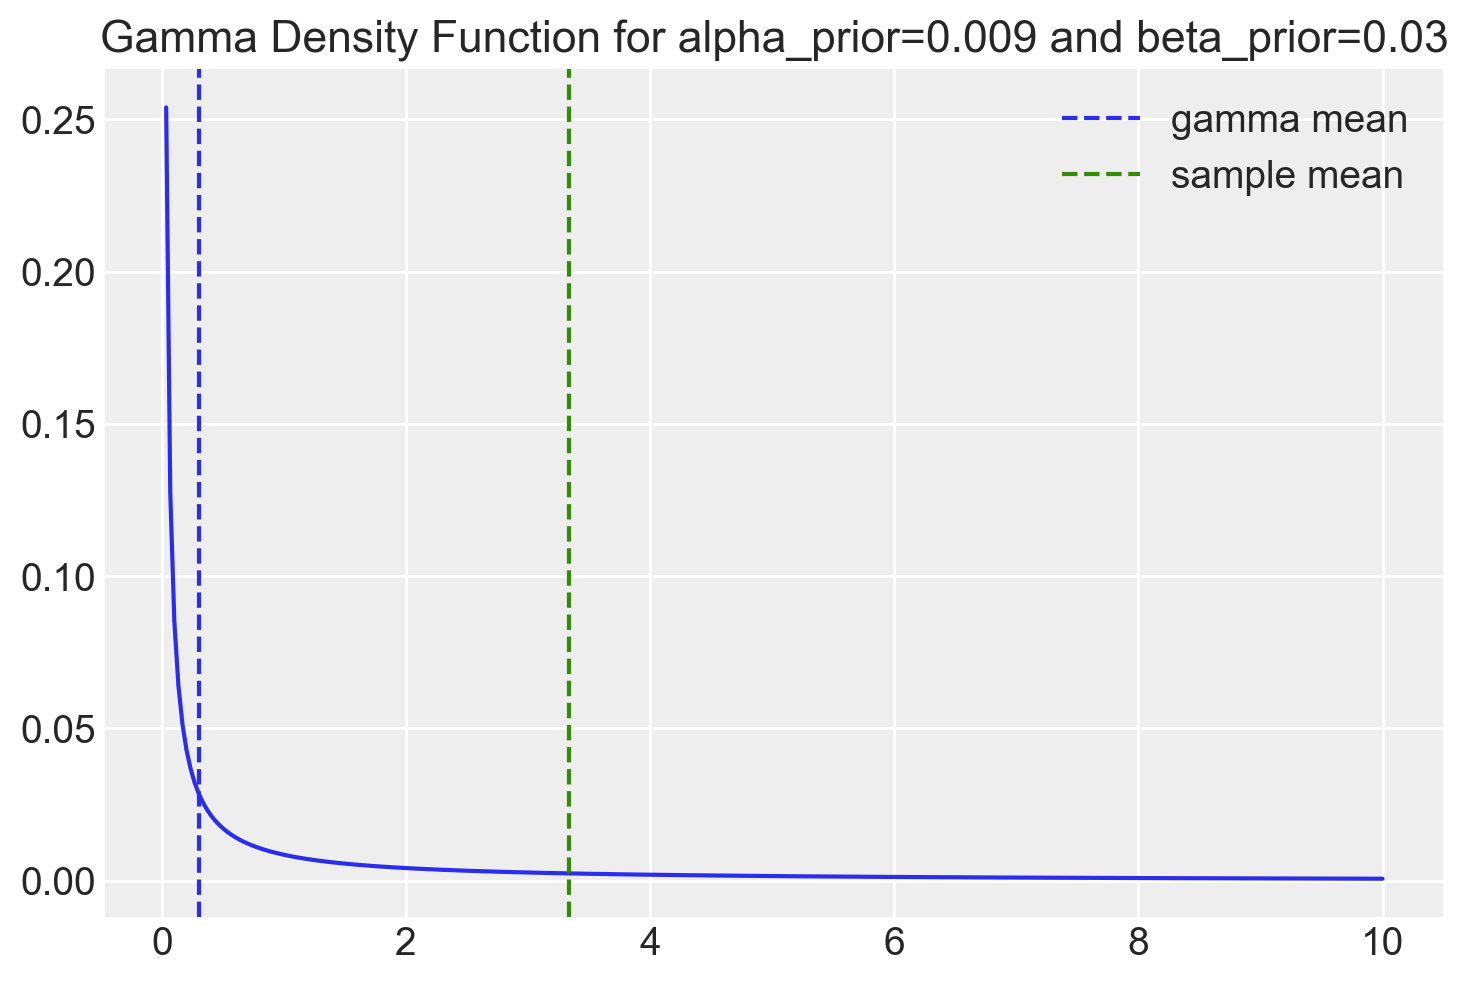

In [36]:
alpha_prior = 0.009
beta_prior = 0.03

x = np.linspace(start=0, stop=10, num=300)

plt.plot(x, stats.gamma.pdf(x, a=alpha_prior, scale=1 / beta_prior))
plt.axvline(x=alpha_prior / beta_prior, linestyle="--", label="gamma mean")
plt.axvline(x=y.mean(), linestyle="--", color="C2", label="sample mean")
plt.legend()
plt.title(f"Gamma Density Function for alpha_prior={0.009} and beta_prior={0.03}")
plt.show()

## Metodo Basato su Griglia

Poniamoci l'obiettivo di usare il metodo basato su griglia per derivare la distribuzione a posteriori per il parametro $\lambda$ della distribuzione esponenziale. Iniziamo con la creazione della griglia per $\lambda$ nell'intervallo [0.01, 10].

In [29]:
# Evita zero per evitare divisione per zero
lambda_grid = np.linspace(0.01, 10, 1000)

Calcoliamo la distribuzione a priori.

In [30]:
prior = stats.gamma.pdf(lambda_grid, a=alpha_prior, scale=1 / beta_prior)

Calcoliamo la verosimiglianza per ciascun valore di lambda.

In [31]:
likelihood = np.ones_like(lambda_grid)
for yi in y:
    likelihood *= stats.expon.pdf(yi, scale=1 / lambda_grid)

Calcoliamo la distribuzione a posteriori non normalizzata.

In [32]:
posterior_unnormalized = likelihood * prior

Normalizziamo la distribuzione a posteriori.

In [33]:
posterior = posterior_unnormalized / np.sum(
    posterior_unnormalized * (lambda_grid[1] - lambda_grid[0])
)

Visualizzazione dei risultati.

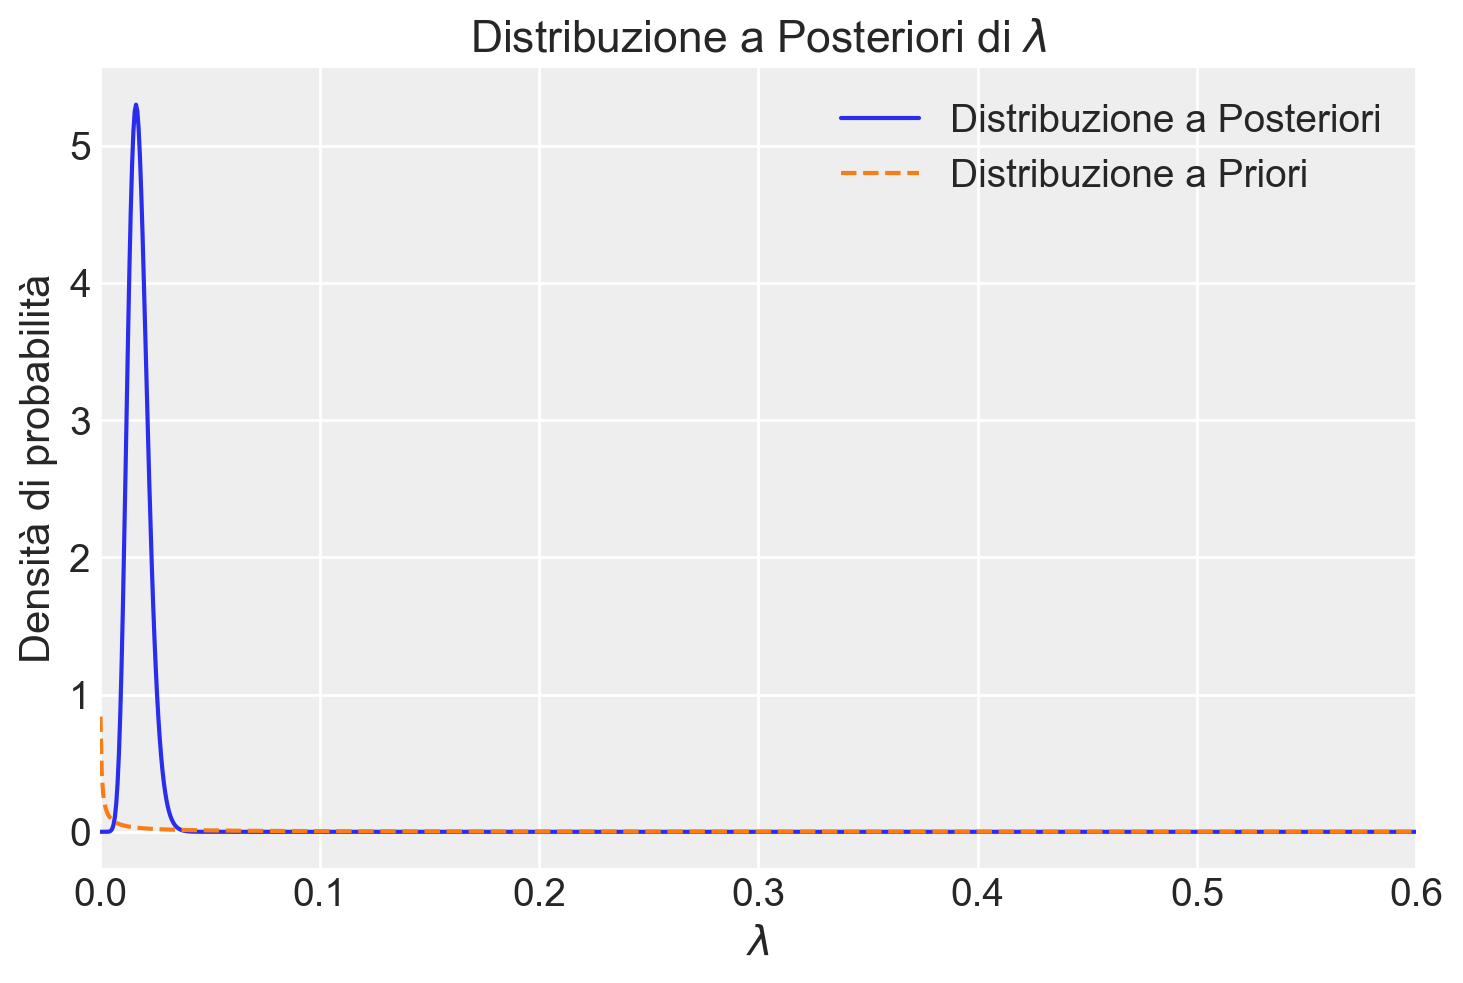

In [65]:
plt.plot(lambda_grid, posterior, label="Distribuzione a Posteriori")
plt.plot(lambda_grid, prior, "--", label="Distribuzione a Priori")
plt.xlabel(r"$\lambda$")
plt.ylabel("Densità di probabilità")
plt.legend()
plt.title("Distribuzione a Posteriori di $\lambda$")
plt.show()

## Modello Coniugato Gamma-Esponenziale

Quando utilizziamo una distribuzione $\text{Gamma}(\alpha, \beta)$ come [distribuzione coniugata a priori](https://en.wikipedia.org/wiki/Conjugate_prior), la distribuzione a posteriori risulta anch'essa essere una distribuzione Gamma, con parametri aggiornati $\alpha + n$ e $\beta + \sum_{i=1}^{n} x_{i}$.

In altre parole, se il parametro $\lambda$ della distribuzione esponenziale segue una distribuzione a priori Gamma con parametri $\alpha$ e $\beta$, allora, dopo aver osservato un campione di $n$ osservazioni $x_1, x_2, \dots, x_n$, la distribuzione a posteriori di $\lambda$ sarà ancora una distribuzione Gamma, ma con i parametri aggiornati:

$$
\lambda \mid x \sim \text{Gamma}(\alpha + n, \beta + \sum_{i=1}^{n} x_{i}).
$$

Questo aggiornamento dei parametri è una conseguenza della proprietà coniugata della distribuzione Gamma rispetto alla distribuzione esponenziale.

### Dimostrazione del Modello Coniugato Gamma-Esponenziale

Per dimostrare questo risultato, partiamo dal teorema di Bayes:

$$
f(\lambda \mid x) \propto f(x \mid \lambda) \cdot f(\lambda),
$$

dove $f(\lambda \mid x)$ è la distribuzione a posteriori di $\lambda$ dato il campione $x$, $f(x \mid \lambda)$ è la verosimiglianza basata sul campione $x$, e $f(\lambda)$ è la distribuzione a priori di $\lambda$.

La funzione di verosimiglianza per un campione di $n$ osservazioni indipendenti $x_1, x_2, \dots, x_n$, che seguono una distribuzione esponenziale con parametro $\lambda$, è data da:

$$
f(x \mid \lambda) = \prod_{i=1}^{n} \lambda e^{-\lambda x_i} = \lambda^n e^{-\lambda \sum_{i=1}^{n} x_i}.
$$

Supponiamo che il parametro $\lambda$ segua una distribuzione a priori Gamma con parametri $\alpha$ e $\beta$:

$$
f(\lambda) = \frac{\beta^\alpha}{\Gamma(\alpha)} \lambda^{\alpha - 1} e^{-\beta \lambda}.
$$

Moltiplicando la verosimiglianza per la distribuzione a priori, otteniamo la distribuzione a posteriori:

$$
f(\lambda \mid x) \propto \lambda^n e^{-\lambda \sum_{i=1}^{n} x_i} \cdot \lambda^{\alpha - 1} e^{-\beta \lambda}.
$$

Semplificando, si ottiene:

$$
f(\lambda \mid x) \propto \lambda^{n + \alpha - 1} e^{-\lambda \left(\beta + \sum_{i=1}^{n} x_i\right)}.
$$

Questa espressione corrisponde alla forma di una distribuzione Gamma con parametri aggiornati:

- parametro della forma (alpha): $\alpha_{\text{post}} = \alpha + n$;
- parametro della scala (beta): $\beta_{\text{post}} = \beta + \sum_{i=1}^{n} x_i$.


Quindi, la distribuzione a posteriori di $\lambda$ dato il campione $x$ segue una distribuzione Gamma con parametri aggiornati:

$$
\lambda \mid x \sim \text{Gamma}(\alpha + n, \beta + \sum_{i=1}^{n} x_i).
$$

Questa derivazione mostra come l'informazione contenuta nei dati osservati venga incorporata nei parametri della distribuzione a posteriori, mantenendo la forma della distribuzione a priori grazie alla proprietà coniugata.

Per il caso dell'esempio in discussione, 

- il numero di osservazioni nel campione $n$ è 15;
- la somma delle osservazioni del campione è:

$$
\sum_{i=1}^{n} y_i = 1 + 9 + 4 + 3 + 1 + 1 + 0 + 6 + 3 + 4 + 0 + 11 + 5 + 1 + 1 = 50
$$

I parametri aggiornati della distribuzione a posteriori sono:

$$
\alpha_{\text{post}} = 15 + 0.009 = 15.009.
$$

$$
\beta_{\text{post}} = 50 + 0.03 = 50.03.
$$

Utilizzando i parametri aggiornati, rappresentiamo graficamente la distribuzione a posteriori.

In [43]:
# Aggiornamento dei parametri per la distribuzione a posteriori
alpha_post = alpha_prior + len(y)
beta_post = beta_prior + np.sum(y)

print(f"alpha_post = {alpha_post}; beta_post = {beta_post:.4f}")

alpha_post = 15.009; beta_post = 50.0300


Quindi, la distribuzione a posteriori di $\lambda$ è:

$$
p(\lambda \mid y) \sim \text{Gamma}(15.009, 50.03).
$$

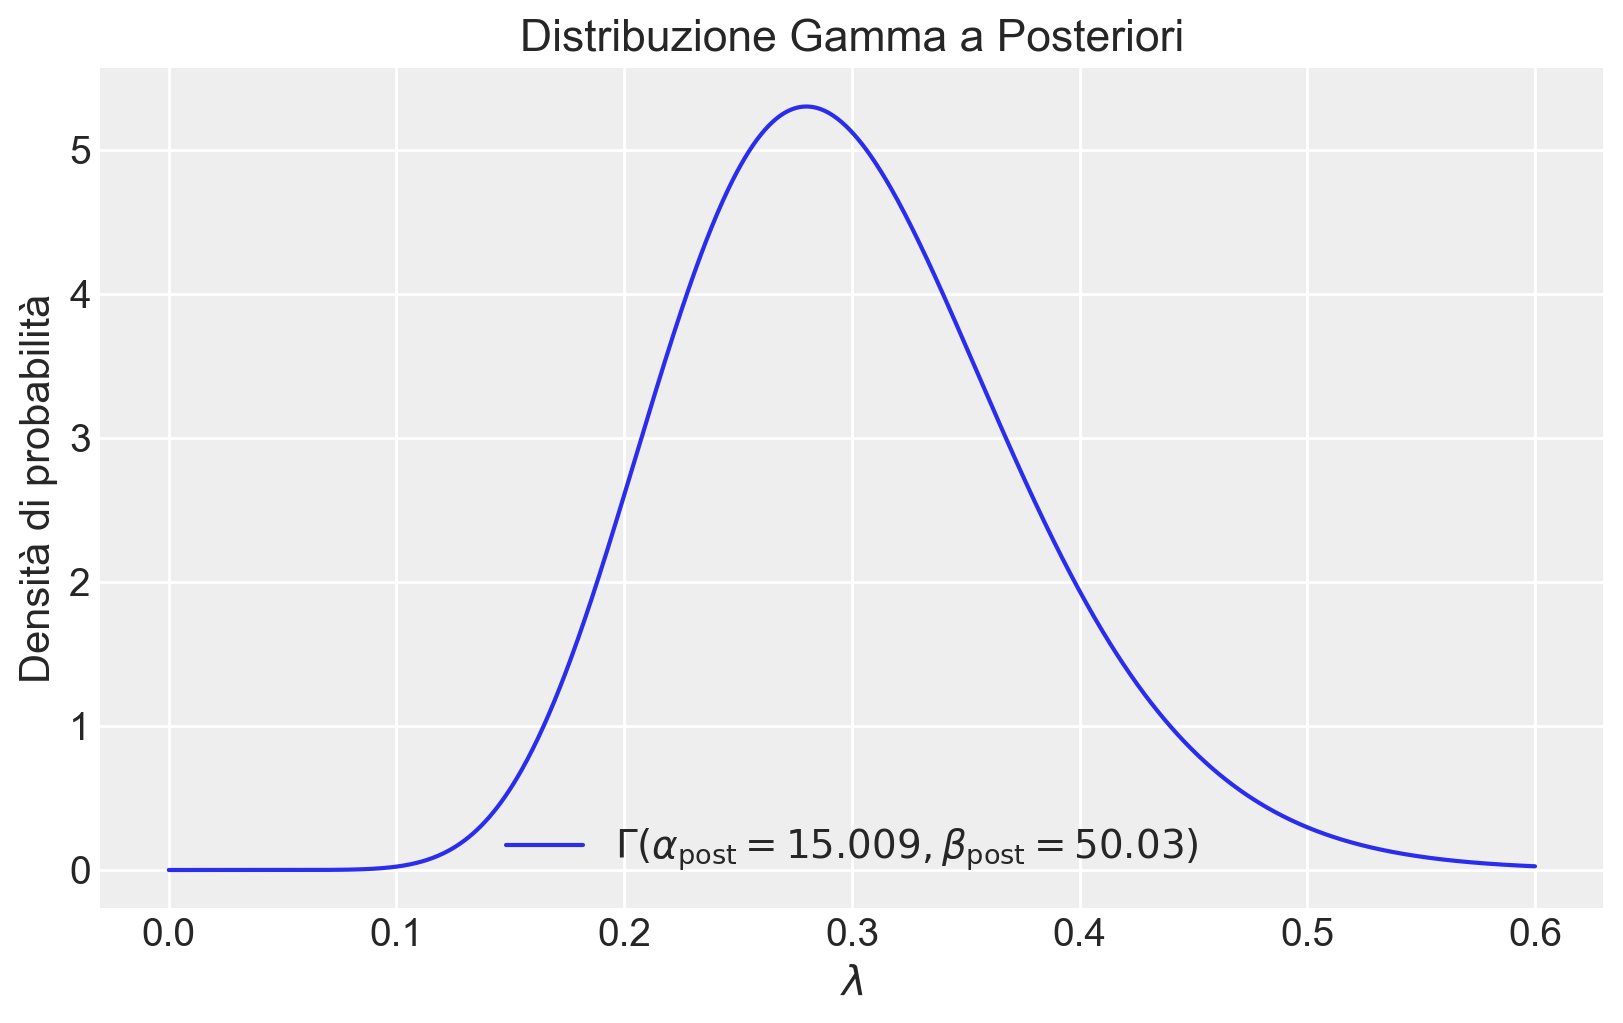

In [61]:
# Parametri della distribuzione Gamma a posteriori
alpha_post = 15.009
beta_post = 50.03

# Griglia di valori di lambda per il plot
lambda_grid = np.linspace(0, 0.6, 1000)

# Calcolo della distribuzione Gamma a posteriori
posterior_pdf = stats.gamma.pdf(lambda_grid, a=alpha_post, scale=1 / beta_post)

# Plot della distribuzione a posteriori
plt.figure(figsize=(8, 5))
plt.plot(
    lambda_grid,
    posterior_pdf,
    label=r"$\Gamma(\alpha_{\text{post}}=15.009, \beta_{\text{post}} = 50.03)$",
)
plt.xlabel(r"$\lambda$")
plt.ylabel("Densità di probabilità")
plt.title("Distribuzione Gamma a Posteriori")
plt.legend()
plt.show()

Questo grafico visualizza la distribuzione a posteriori analitica per il parametro $\lambda$ del modello gamma-esponenziale. Il risultato replica quello ottenuto mediante simulazione numerica.

Questa distribuzione Gamma a posteriori riflette l'informazione combinata proveniente sia dal prior che dai dati osservati. Con $\alpha_{\text{posteriori}} = 15.009$ e $\beta_{\text{posteriori}} = 50.03$, la distribuzione a posteriori di $\lambda$ sarà centrata attorno alla media:

$$
\text{E}[\lambda \mid y] = \frac{\alpha_{\text{posteriori}}}{\beta_{\text{posteriori}}} \approx \frac{15.009}{50.03} \approx 0.3
$$

e con varianza:

$$
\text{Var}[\lambda \mid y] = \frac{\alpha_{\text{posteriori}}}{\beta_{\text{posteriori}}^2} \approx \frac{15.009}{50.03^2} \approx 0.006
$$

La distribuzione a posteriori sarà più concentrata rispetto al prior, poiché incorpora l'informazione aggiuntiva proveniente dai dati osservati.

### Applicazioni

Possiamo ora rispondere a domande riguardanti la probabilità che una nuova osservazione $y$ assuma determinati valori. Nel caso dell'esempio, ad esempio ci possiamo chiedere quale sia la probabilità degli eventi $y > 5$ (disagio psicologico lieve) o $y > 13$ (disagio psicologico severo). Utilizzando la distribuzione a posteriori di $\lambda$, possiamo procedere calcolando le probabilità richieste utilizzando simulazioni Monte Carlo.

Per il caso della probabilità che $y \geq 5$, 

1. Generiamo un campione di valori di $\lambda$ dalla distribuzione a posteriori $\lambda \sim \text{Gamma}(15.009, 50.03)$.
2. Generiamo un campione di valori di $y$ per ciascun $\lambda$ dalla distribuzione esponenziale $y \sim \text{Expon}(\lambda)$.
3. Calcoliamo la proporzione di valori di $y$ che sono maggiori o uguali a 5.

In [62]:
# Numero di simulazioni
n_sim = 10000

# Generazione di un campione di lambda dalla distribuzione a posteriori
lambda_samples = stats.gamma.rvs(a=alpha_post, scale=1 / beta_post, size=n_sim)

# Generazione di un campione di y dalla distribuzione esponenziale per ciascun lambda
y_samples = stats.expon.rvs(scale=1 / lambda_samples, size=n_sim)

# Calcolo della probabilità che y >= 5
prob_y_ge_5 = np.mean(y_samples >= 5)
print(f"Probabilità che y >= 5: {prob_y_ge_5:.4f}")

# Calcolo della probabilità che y > 13
prob_y_gt_13 = np.mean(y_samples > 13)
print(f"Probabilità che y > 13: {prob_y_gt_13:.4f}")

Probabilità che y >= 5: 0.2322
Probabilità che y > 13: 0.0317


- Probabilità che $y \geq 5$: Questo valore rappresenta la probabilità che un nuovo individuo abbia un disagio psicologico almeno moderato (definito come $y \geq 5$).
- Probabilità che $y > 13$: Questo valore rappresenta la probabilità che un nuovo individuo abbia un disagio psicologico severo (definito come $y > 13$).

La probabilità del 23.22% di osservare un punteggio di 5 o superiore sulla scala K6 suggerisce che circa un quarto degli individui potrebbe sperimentare un livello di disagio psicologico almeno moderato. La probabilità del 3.17% di osservare un punteggio superiore a 13 indica che una piccola ma significativa percentuale di individui potrebbe sperimentare un disagio psicologico severo.

## Considerazioni Conclusive

Il modello esponenziale si rivela uno strumento utile e versatile nella ricerca psicologica, particolarmente adatto per modellare fenomeni caratterizzati da tempi di attesa o durate di eventi. La sua applicazione spazia dall'analisi dei tempi di reazione agli studi sulla durata degli episodi di ansia o depressione, fornendo preziose intuizioni sui processi psicologici sottostanti.

L'approccio bayesiano all'inferenza con il modello esponenziale offre diversi vantaggi:

1. Flessibilità nell'incorporazione di conoscenze pregresse: Attraverso la scelta informata della distribuzione a priori, i ricercatori possono integrare conoscenze esistenti o risultati di studi precedenti, migliorando la robustezza delle inferenze.

2. Interpretabilità diretta dei risultati: La distribuzione a posteriori fornisce una stima probabilistica completa del parametro di interesse, permettendo ai ricercatori di fare affermazioni dirette sulla probabilità di diversi valori del parametro.

3. Gestione dell'incertezza: L'approccio bayesiano quantifica esplicitamente l'incertezza nelle stime, fornendo intervalli di credibilità che sono più intuitivi e direttamente interpretabili rispetto agli intervalli di confidenza frequentisti.

4. Facilità di aggiornamento delle conoscenze: Man mano che nuovi dati diventano disponibili, la distribuzione a posteriori può essere utilizzata come nuova distribuzione a priori, permettendo un aggiornamento continuo e coerente delle conoscenze.

5. Robustezza con campioni piccoli: L'inferenza bayesiana può fornire risultati significativi anche con campioni di dimensioni ridotte, una situazione comune in molti studi psicologici.

In conclusione, l'utilizzo del modello esponenziale all'interno del framework bayesiano offre agli psicologi un potente strumento per analizzare e interpretare dati relativi a tempi e durate. Questo approccio non solo fornisce stime più ricche e interpretabili dei parametri di interesse, ma permette anche una più naturale integrazione di conoscenze pregresse e una quantificazione esplicita dell'incertezza. 

## Informazioni sull'Ambiente di Sviluppo

In [22]:
%load_ext watermark
%watermark -n -u -v -iv -w -m

Last updated: Sun Jun 02 2024

Python implementation: CPython
Python version       : 3.12.3
IPython version      : 8.24.0

Compiler    : Clang 16.0.6 
OS          : Darwin
Release     : 23.4.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit

numpy     : 1.26.4
pymc      : 5.15.0
scipy     : 1.13.0
arviz     : 0.18.0
matplotlib: 3.8.4
pandas    : 2.2.2

Watermark: 2.4.3

